## 📌 GRU 모델을 이용한 JYP 주가 예측

### 사용변수 : 주식데이터 , 기술적보조지표, 트렌드,  감성지수, 이벤트

In [23]:
#!pip install torchvision

In [24]:
import torch
import torch.nn
import torchvision.transforms as transforms
import torchvision.datasets
from torch.autograd import Variable
from torch.nn import Parameter
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math

import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

In [25]:
plt.style.use('seaborn-whitegrid')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)

if torch.cuda.is_available() :
    torch.cuda.manual_seed_all(125)

In [26]:
#!pip install yfinance

## 1. 데이터 형태 확인

In [27]:
import pandas as pd
import numpy as np
df = pd.read_csv("../../../../data/FINALDATA/jyp.csv")
date=df['DATE']
df.set_index('DATE',inplace=True)
df

,Open,High,Low,Close,Volume,Change,MACD,Signal,PSAR,upper,...,OBV,FI,keyword,view_log_like_sum,view_log_like_avg,count,trend,DAY,SENTIMENT,EVENT
DATE,,,,,,,,,,,,,,,,,,,,,
2023-01-02,67800.0,68200.0,64300.0,67200.0,467158.0,-0.008850,2079.996957,2311.228174,68400.000000,68967.412881,...,3717064.0,-2.802948e+08,185.23899,1.158189e+07,7.547273e+06,2.0,20.999291,월,25.008631,NaN
2023-01-03,66900.0,69400.0,66500.0,68000.0,514102.0,0.011905,2032.604575,2255.503454,64300.000000,69211.706023,...,4231166.0,4.112816e+08,85.53988,1.366618e+07,6.833088e+06,2.0,20.625456,화,175.724840,NaN
2023-01-04,67500.0,67600.0,64600.0,65100.0,724974.0,-0.042647,1740.971175,2152.596998,64300.000000,69150.320496,...,3506192.0,-2.102425e+09,82.35776,6.591036e+06,2.197012e+06,3.0,19.569673,수,21.097298,NaN
2023-01-05,65100.0,65800.0,63200.0,64600.0,391061.0,-0.007680,1452.757301,2012.629059,69400.000000,69034.030452,...,3115131.0,-1.955305e+08,86.81160,1.791291e+07,8.956455e+06,2.0,20.910812,목,277.915244,NaN
2023-01-06,64500.0,64500.0,62200.0,63100.0,483954.0,-0.023220,1090.734952,1828.250237,69276.000000,69076.397837,...,2631177.0,-7.259310e+08,86.99896,5.819490e+06,5.819490e+06,1.0,20.315133,금,393.110160,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,129300.0,131400.0,128500.0,130000.0,329926.0,-0.009901,6830.728487,8412.138252,140172.000000,142102.345499,...,19558819.0,-4.289038e+08,83.99566,2.430902e+07,7.736225e+06,2.0,20.218081,월,94.132075,NaN
2023-06-27,129300.0,130300.0,122300.0,124900.0,794119.0,-0.039231,5754.775453,7880.665693,139471.680000,140295.960068,...,18764700.0,-4.050007e+09,88.10603,7.187662e+07,1.796915e+07,4.0,21.827102,화,NaN,NaN
2023-06-28,126300.0,126500.0,122500.0,122600.0,413691.0,-0.018415,4662.735037,7237.079562,138097.945600,140244.360010,...,18351009.0,-9.514893e+08,95.75902,1.414524e+07,2.829049e+06,5.0,20.131995,수,NaN,NaN


In [28]:
df.isna().sum()

Open                   0
High                   0
Low                    0
Close                  0
Volume                 0
Change                 0
MACD                   0
Signal                 0
PSAR                   0
upper                  0
middle                 0
lower                  0
SlowK                  0
SlowD                  0
ROC                    0
OBV                    0
FI                     0
keyword                0
view_log_like_sum      0
view_log_like_avg      0
count                  0
trend                  0
DAY                    0
SENTIMENT              6
EVENT                114
dtype: int64

In [29]:
df.loc[df['Close'].isna()]

,Open,High,Low,Close,Volume,Change,MACD,Signal,PSAR,upper,...,OBV,FI,keyword,view_log_like_sum,view_log_like_avg,count,trend,DAY,SENTIMENT,EVENT
DATE,,,,,,,,,,,,,,,,,,,,,


In [30]:
# df.drop(index='2023-05-05',inplace=True)

In [31]:
df.fillna(0,inplace=True)
df.isna().sum()

Open                 0
High                 0
Low                  0
Close                0
Volume               0
Change               0
MACD                 0
Signal               0
PSAR                 0
upper                0
middle               0
lower                0
SlowK                0
SlowD                0
ROC                  0
OBV                  0
FI                   0
keyword              0
view_log_like_sum    0
view_log_like_avg    0
count                0
trend                0
DAY                  0
SENTIMENT            0
EVENT                0
dtype: int64

In [32]:
df.info()
drop_columns=['Close','view_log_like_sum','view_log_like_avg','count','DAY','keyword']

<class 'pandas.core.frame.DataFrame'>
Index: 123 entries, 2023-01-02 to 2023-06-30
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               123 non-null    float64
 1   High               123 non-null    float64
 2   Low                123 non-null    float64
 3   Close              123 non-null    float64
 4   Volume             123 non-null    float64
 5   Change             123 non-null    float64
 6   MACD               123 non-null    float64
 7   Signal             123 non-null    float64
 8   PSAR               123 non-null    float64
 9   upper              123 non-null    float64
 10  middle             123 non-null    float64
 11  lower              123 non-null    float64
 12  SlowK              123 non-null    float64
 13  SlowD              123 non-null    float64
 14  ROC                123 non-null    float64
 15  OBV                123 non-null    float64
 16  FI             

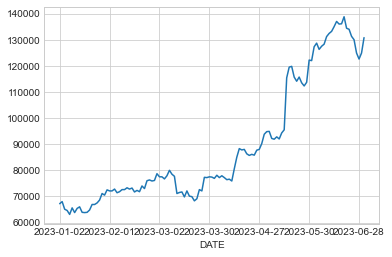

In [33]:
fig = df['Close'].plot()

In [34]:
X = df.drop(drop_columns, axis=1) # X, y 분리
y = df[['Close']]

In [35]:
X.fillna(0,inplace=True)
X.isna().sum()
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 123 entries, 2023-01-02 to 2023-06-30
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       123 non-null    float64
 1   High       123 non-null    float64
 2   Low        123 non-null    float64
 3   Volume     123 non-null    float64
 4   Change     123 non-null    float64
 5   MACD       123 non-null    float64
 6   Signal     123 non-null    float64
 7   PSAR       123 non-null    float64
 8   upper      123 non-null    float64
 9   middle     123 non-null    float64
 10  lower      123 non-null    float64
 11  SlowK      123 non-null    float64
 12  SlowD      123 non-null    float64
 13  ROC        123 non-null    float64
 14  OBV        123 non-null    float64
 15  FI         123 non-null    float64
 16  trend      123 non-null    float64
 17  SENTIMENT  123 non-null    float64
 18  EVENT      123 non-null    float64
dtypes: float64(19)
memory usage: 19.2+ KB


## 2. 8:2 로 train test 분리

In [36]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

ms = MinMaxScaler() # 0 ~ 1
ss = StandardScaler() # 평균 0, 분산 1

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:99, :] 
X_test = X_ss[99:, :]

y_train = y_ms[:99, :]
y_test = y_ms[99:, :]

print('Training Shape :', X_train.shape, y_train.shape)
print('Testing Shape :', X_test.shape, y_test.shape)

Training Shape : (99, 19) (99, 1)
Testing Shape : (24, 19) (24, 1)


In [37]:
# 데이터셋 형태 및 크기 조정
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, 
                                  (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))

X_test_tensors_f = torch.reshape(X_test_tensors,
                                (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print('Training Shape :', X_train.shape, y_train.shape)
print('Testing Shape :', X_test.shape, y_test.shape)

Training Shape : (99, 19) (99, 1)
Testing Shape : (24, 19) (24, 1)


## 3. GRU 모델 설정

In [38]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class GRU(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length, dropout_prob=0.0):
        super(GRU, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.dropout = nn.Dropout(p=dropout_prob)  # Dropout layer added
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        output, (hn) = self.gru(x, (h_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.dropout(out)  # Applying dropout before the final fully connected layer
        out = self.fc(out)
        return out


In [39]:
num_epochs = 1500
learning_rate = 0.0003
dropout_prob = 0.3

input_size=19
hidden_size=20 
num_layers=1 

num_classes=1
model=GRU(num_classes,input_size,hidden_size,num_layers,X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [40]:
for epoch in range(num_epochs) :
    outputs = model.forward(X_train_tensors_f)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0 :
        print(f'Epoch : {epoch}, loss : {loss.item():1.5f}')

Epoch : 0, loss : 0.19695
Epoch : 100, loss : 0.01199
Epoch : 200, loss : 0.00469
Epoch : 300, loss : 0.00157
Epoch : 400, loss : 0.00044
Epoch : 500, loss : 0.00019
Epoch : 600, loss : 0.00010
Epoch : 700, loss : 0.00006
Epoch : 800, loss : 0.00004
Epoch : 900, loss : 0.00003
Epoch : 1000, loss : 0.00002
Epoch : 1100, loss : 0.00002
Epoch : 1200, loss : 0.00001
Epoch : 1300, loss : 0.00001
Epoch : 1400, loss : 0.00001


In [41]:
df_x_ss = ss.transform(X)
df_y_ms = ms.transform(y)

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

## 4. 예측된 주식 값과 실제 주식 값을 시각화

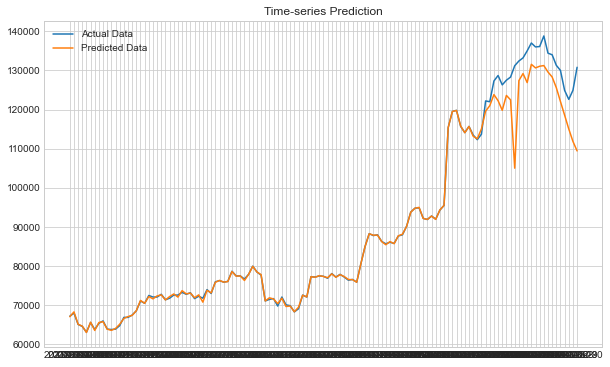

In [42]:
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()

label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10, 6))
# plt.axvline(x=datetime(2022,5,1), c='r', linestyle='--')

df['pred'] = predicted
plt.plot(df['Close'], label='Actual Data')
plt.plot(df['pred'], label='Predicted Data')

plt.title('Time-series Prediction')
plt.legend()
plt.show()

## 5. RMSE 계산

In [43]:
from sklearn.metrics import mean_squared_error
import numpy as np

# 예측값과 실제값을 NumPy 배열로 변환
predicted = np.array(df['pred'])
actual = np.array(df['Close'])

# RMSE 계산
rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f'RMSE: {rmse}')


RMSE: 3998.9517750002015


## 6. 데이터 내보내기

In [44]:
JYP_ALL_GRU=pd.DataFrame({'DATE':date,'predicted':predicted,'actual':actual})
JYP_ALL_GRU.set_index('DATE',inplace=True)
JYP_ALL_GRU

,predicted,actual
DATE,,
2023-01-02,67081.507812,67200.0
2023-01-03,68312.710938,68000.0
2023-01-04,65128.894531,65100.0
2023-01-05,64664.945312,64600.0
2023-01-06,63046.207031,63100.0
...,...,...
2023-06-26,122046.562500,130000.0
2023-06-27,118569.460938,124900.0
2023-06-28,115045.468750,122600.0
